<a href="https://colab.research.google.com/github/alex-hobby/wake/blob/main/ssvep_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyxdf
! pip install gdown

In [ ]:
import urllib.request
import numpy as np
import scipy
import os
import itertools
from scipy.io import wavfile
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pyxdf
from scipy.interpolate import interp1d
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.fft import fft, fftfreq
from numpy import genfromtxt
rng = np.random.default_rng(42)
plt.style.use('seaborn')


def butter_highpass(cutoff=5, fs=250, order=4):
  nyq = 0.5 * fs
  normal_cutoff = cutoff / nyq
  sos = butter(order, normal_cutoff, btype='high', output='sos')
  return sos

def butter_bandpass(lowcut=5, highcut=50, fs=250, order=4):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  sos = butter(order, [low, high], analog=False, btype='band', output='sos')
  return sos

def butter_bandpass_filter(data, lowcut, highcut, fs=250, axis=0, order=4):
  sos = butter_bandpass(lowcut, highcut, fs, order)
  y = sosfilt(sos, data, axis)
  return y

def butter_highpass_filter(data, cutoff, fs=250, axis=0, order=4):
  sos = butter_highpass(cutoff, fs, order)
  y = sosfilt(sos, data, axis)
  return y

def write_file(file_content, file_path, flag='w+'):
  with open(file_path, flag) as fp:
    fp.write(file_content)

def write_url_content_to_file(url, file_path, flag='wb'):
  write_file(urllib.request.urlopen(url).read(), file_path, flag)

def get_scale_factor(gain=24):
  return 4.5 / 24 / (2 ** 23 - 1) * 1e6

sample_data



In [ ]:
control_byte_dict = {
  'discard': 0,
  'quiet_period_start': 1,
  'quiet_period_end': 2,
  'one_tone_start': 3,
  'one_tone_end': 4,
  'two_tone_start': 5,
  'two_tone_end': 6
}

control_str = {val: key for key, val in control_byte_dict.items()}
file_path = 'sample_data/test.xdf'
data, header = pyxdf.load_xdf(file_path)
data_stream_name_to_ind = {d['info']['name'][0]: i for i, d in enumerate(data)}
eeg_data_i = data_stream_name_to_ind['obci_eeg1']
eeg_data = data[eeg_data_i]
eeg_timeseries = eeg_data['time_series'] * get_scale_factor()
eeg_timestamps = eeg_data['time_stamps']


(9520, 8)


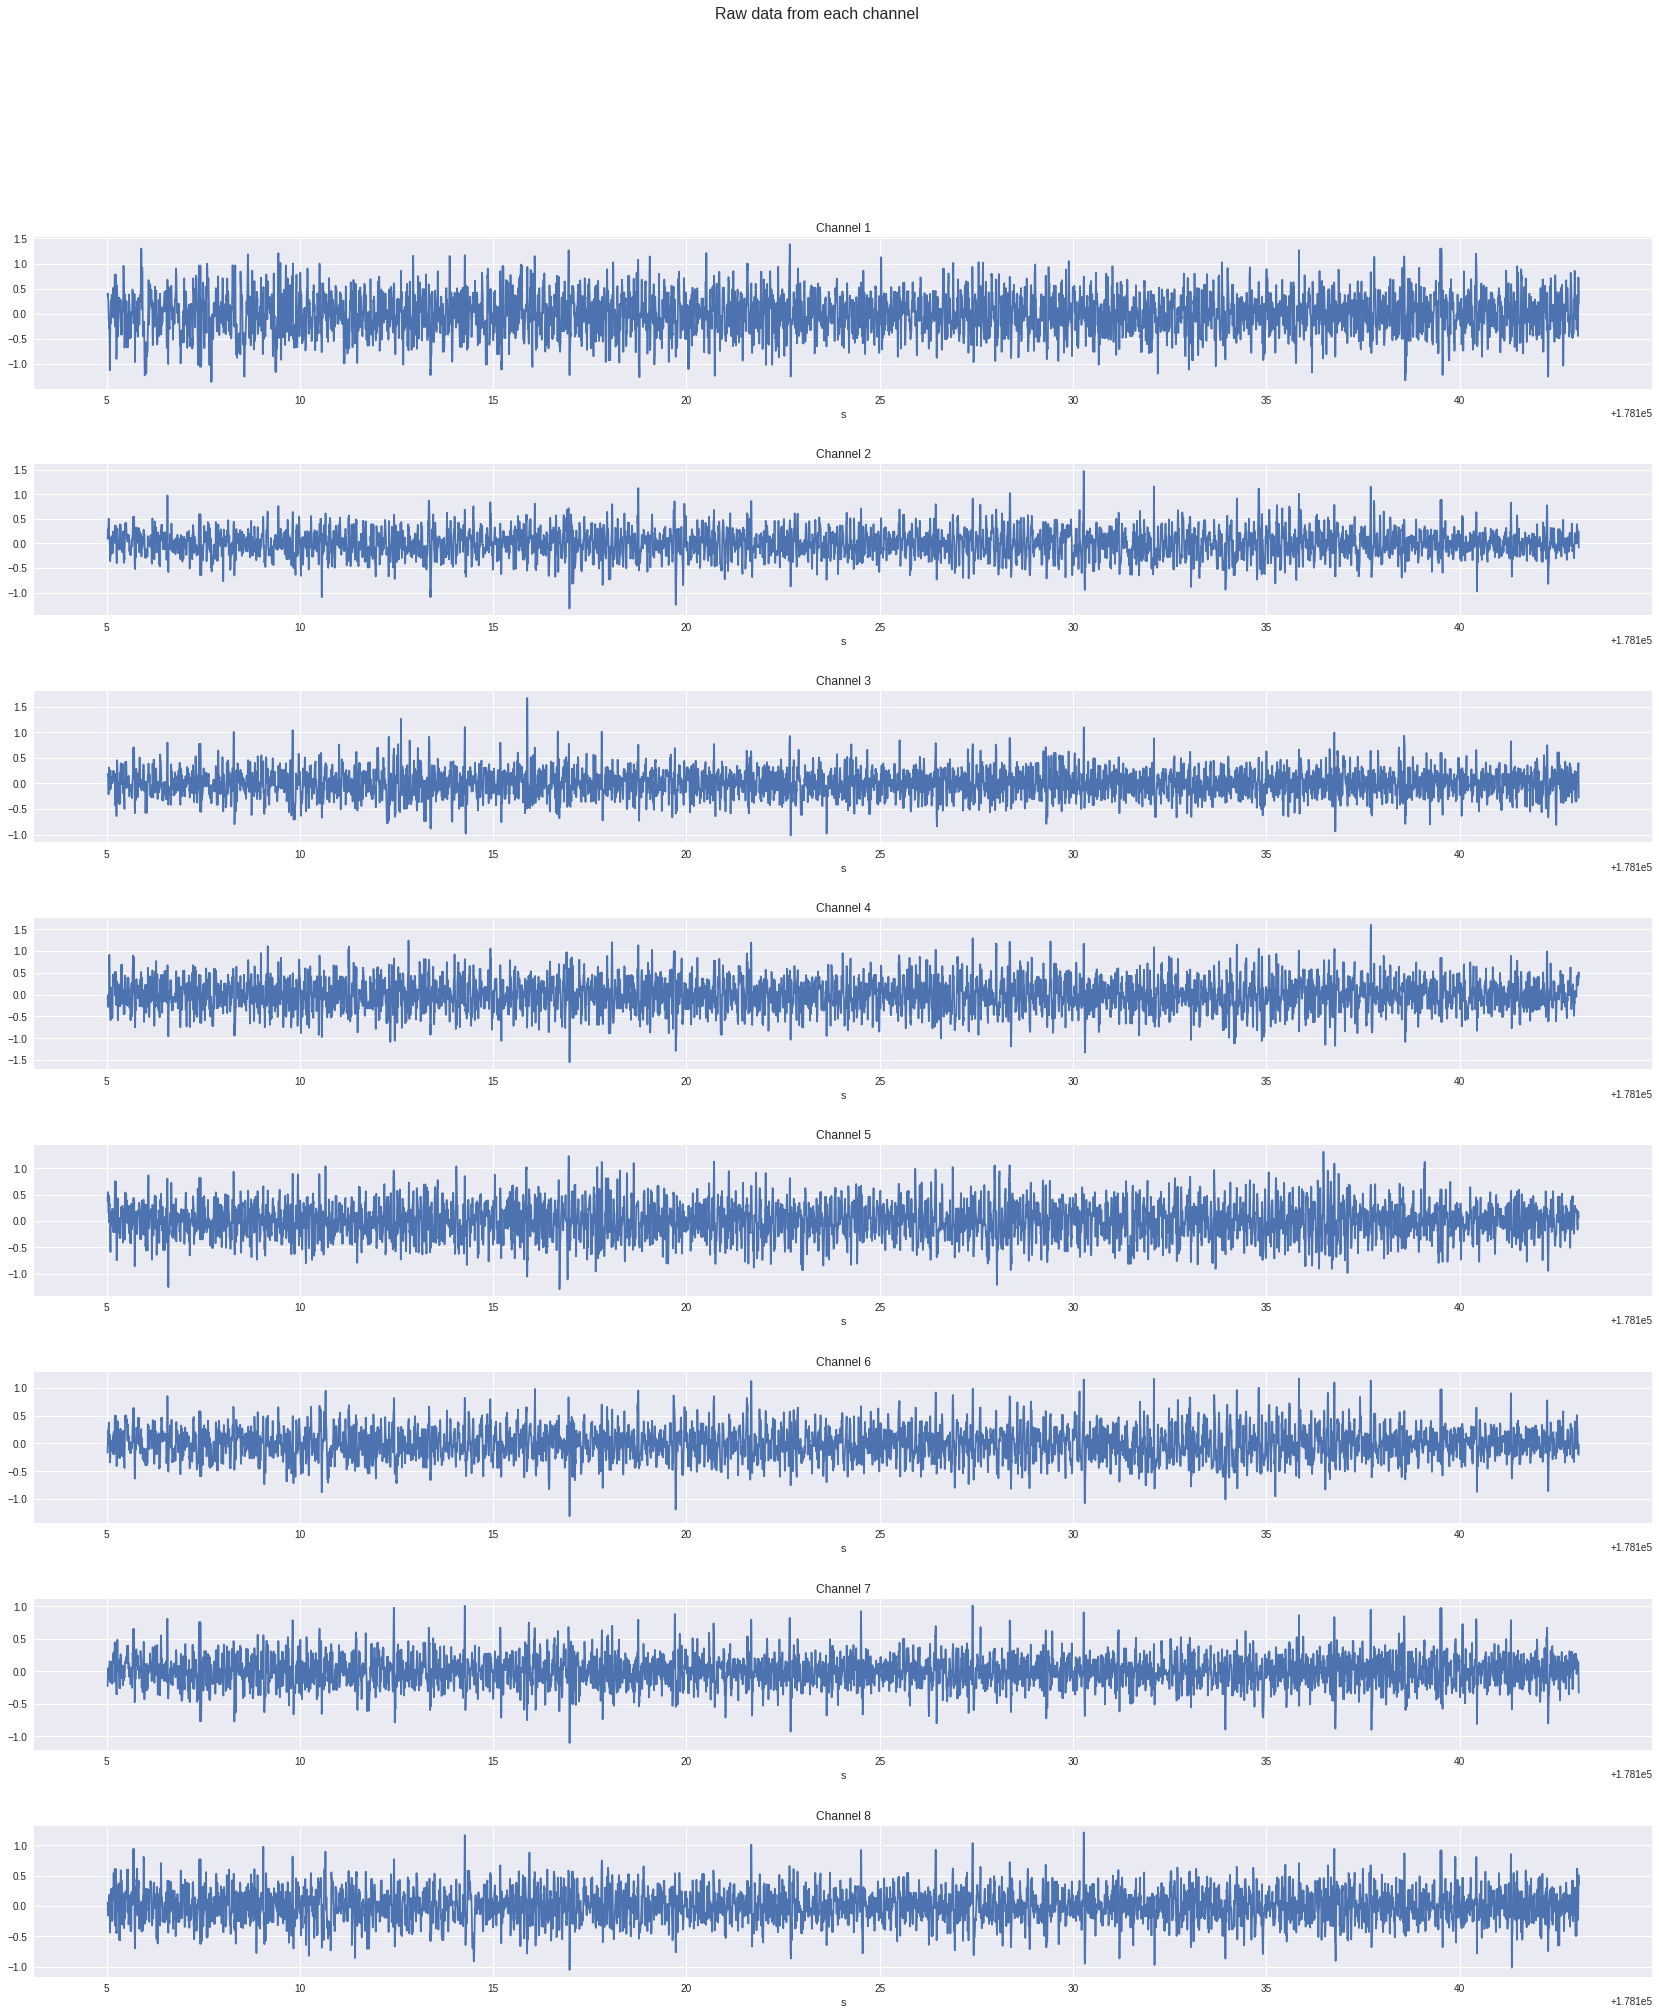

In [ ]:
print(eeg_timeseries.shape)
fig = plt.figure(figsize=(29, 32))
fig.suptitle('Raw data from each channel',fontsize=16)
fig.subplots_adjust(hspace=0.5)
for i in range(eeg_timeseries.shape[1]):
  plt.subplot(8, 1, i+1)
  plt.plot(eeg_timestamps, eeg_timeseries[:, i])
  plt.xlabel('s')
  plt.title(f'Channel {i+1}')

plt.show()

(9520, 8)


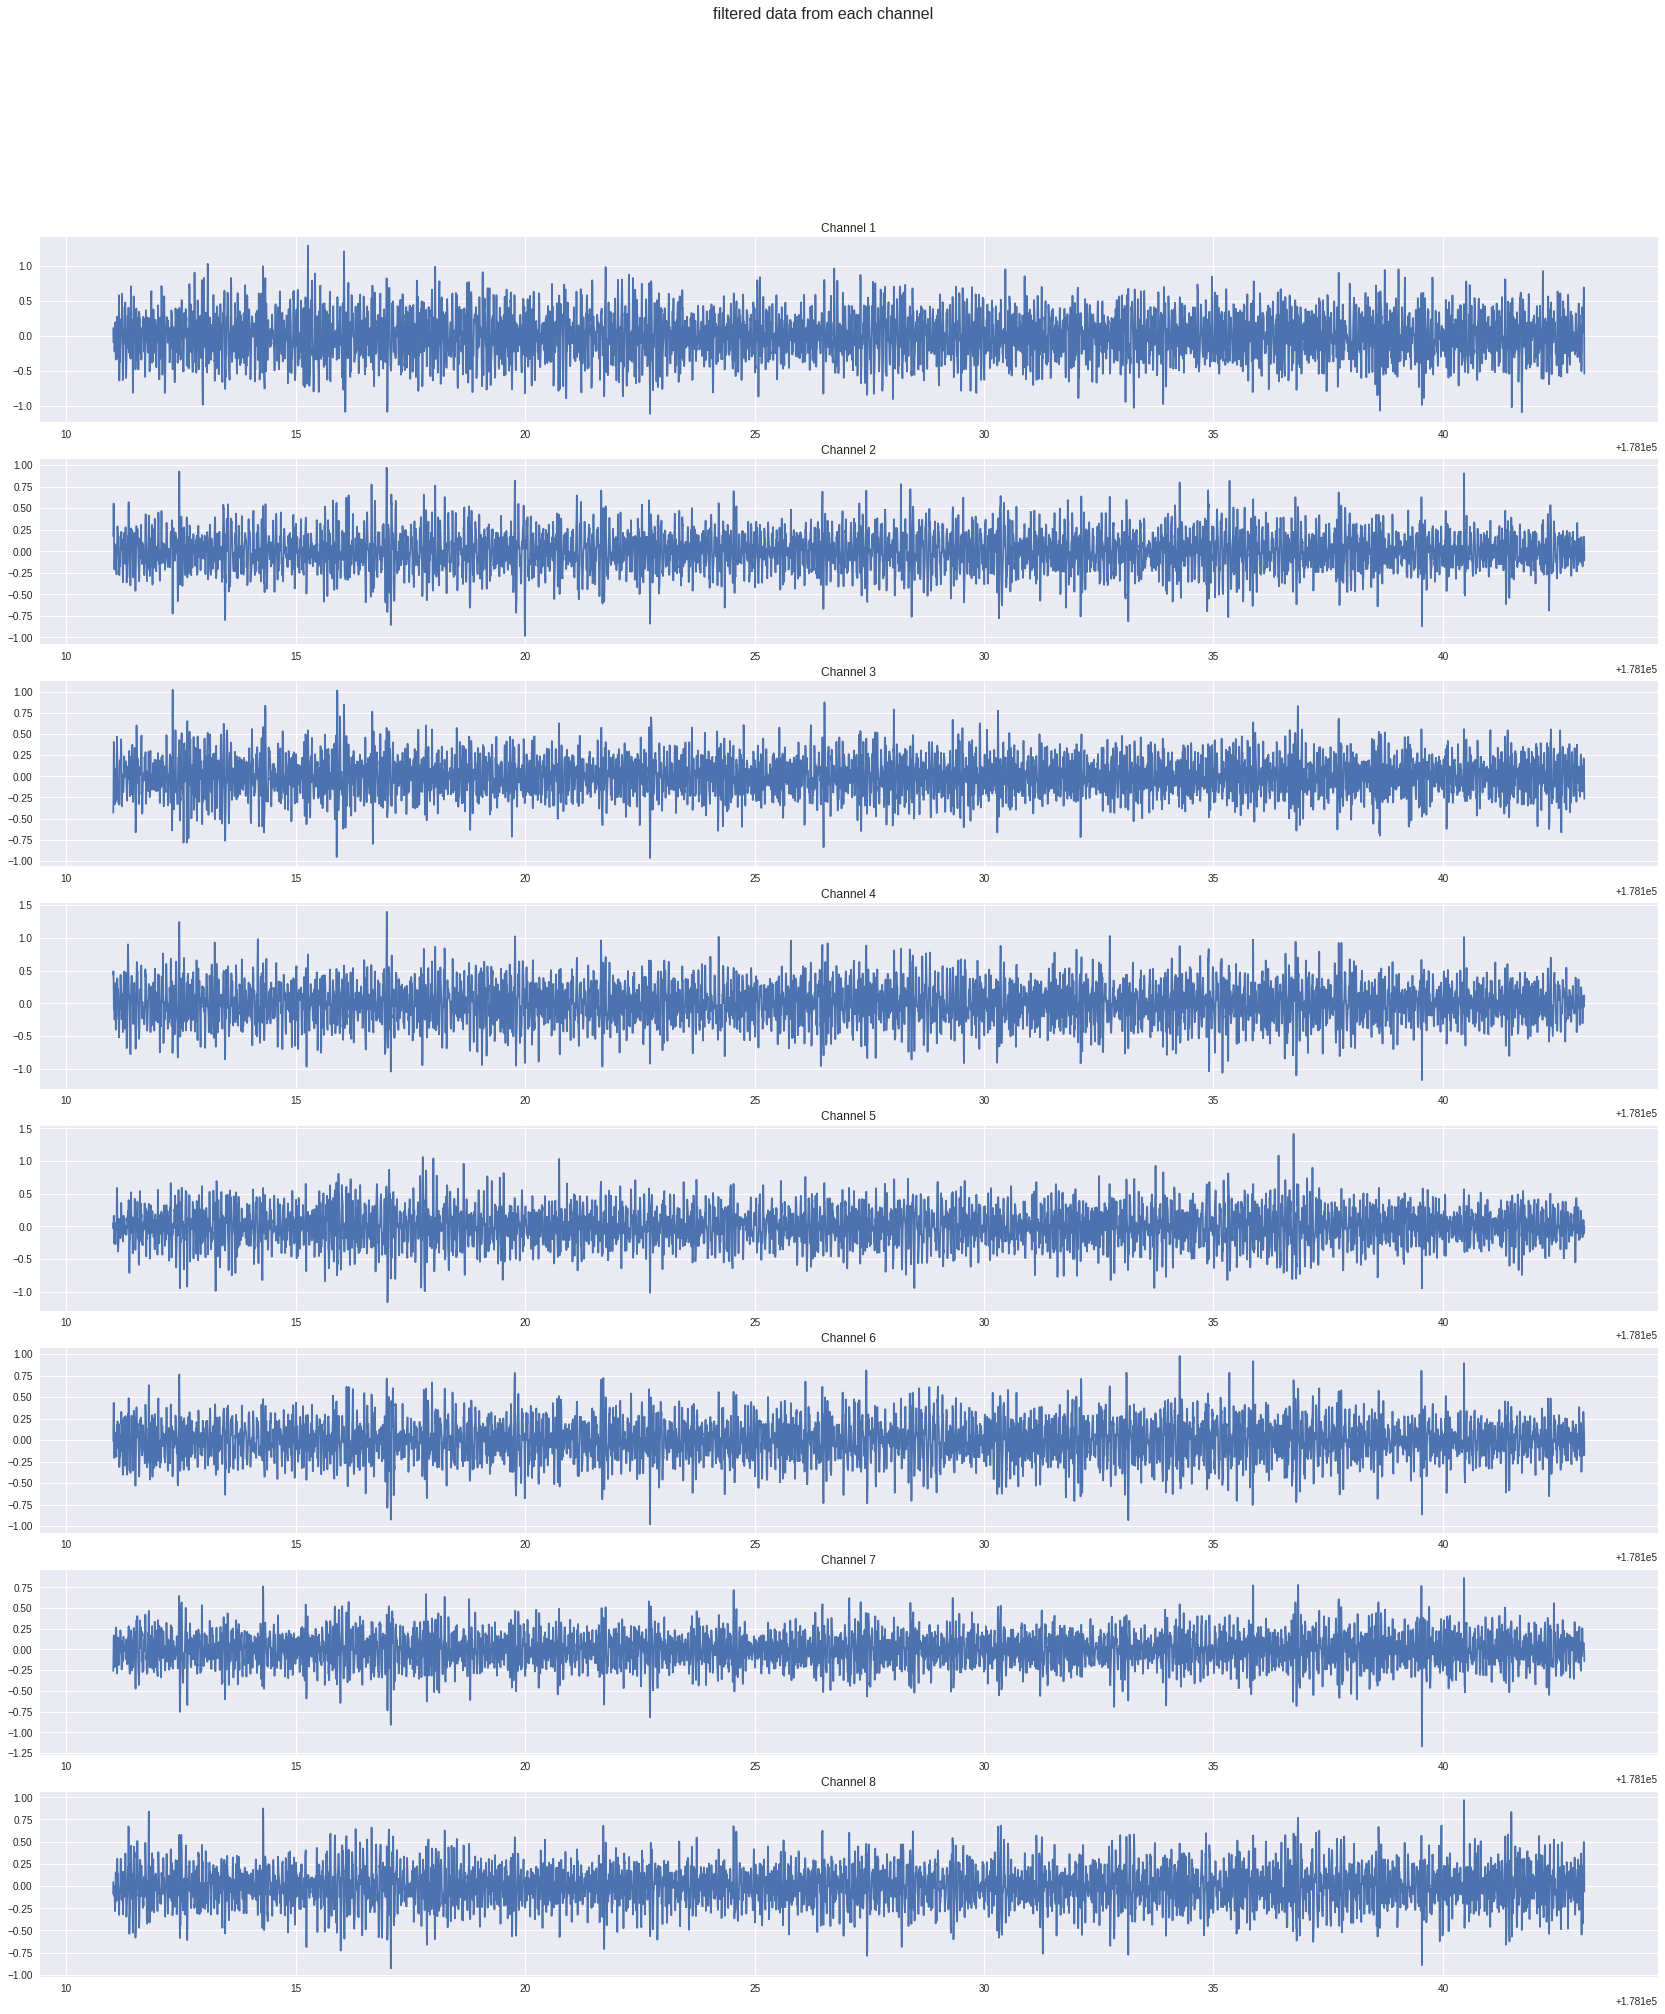

In [ ]:
print(eeg_timeseries_filtered.shape)
fig = plt.figure(figsize=(29, 32))
fig.suptitle('filtered data from each channel',fontsize=16)
for i in range(eeg_timeseries_filtered.shape[1]):
  plt.subplot(8, 1, i+1)
  plt.plot(eeg_timestamps[1500:], eeg_timeseries_filtered[1500:, i])
  plt.title(f'Channel {i+1}')

plt.show()

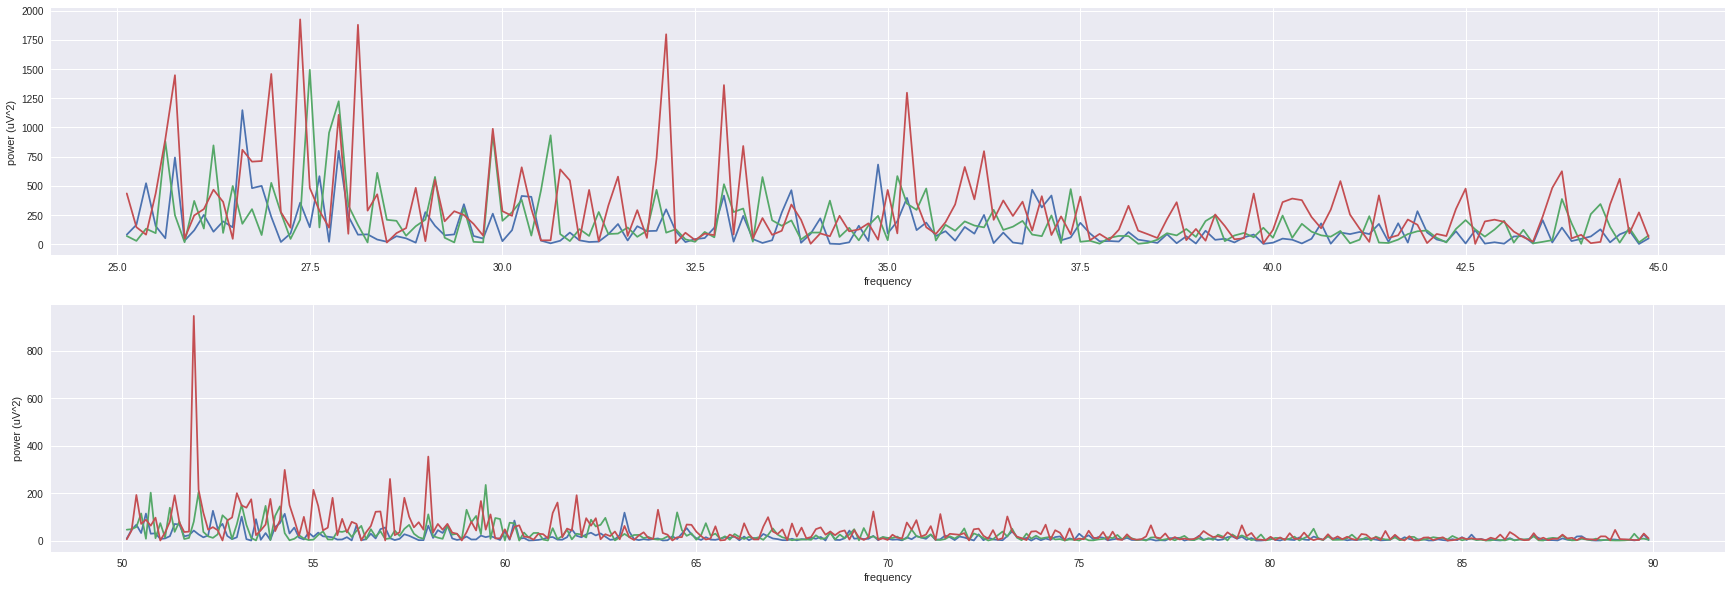

In [ ]:
trial_index = 8
trial_data = eeg_timeseries_filtered
fft_win = 2000
SAMPLE_RATE = 250
DURATION_S = fft_win / 250
DELAY_S = 0.3
DELAY_FRAME = int(SAMPLE_RATE * DELAY_S)
N = fft_win
xf = fftfreq(N, 1 / SAMPLE_RATE)
xf_mask = (xf > 20) & (xf < 80)
selected_xf = xf[xf_mask]
window = np.ones(fft_win).reshape((fft_win, 1))
# channels=[0, 1, 2, 3, 4, 5, 6, 7]
channels=[1, 2, 3]
fig = plt.figure(figsize=(30, 10))
plt.subplot(2, 1, 1)
xf_mask = (xf > 25) & (xf < 45)
selected_xf = xf[xf_mask]
trial_data = trial_data[DELAY_FRAME: DELAY_FRAME + fft_win, :]
trial_data_fft = np.power(np.abs(fft(trial_data[:, channels] * window, axis=0)), 2)
plt.plot(selected_xf, trial_data_fft[xf_mask])
plt.vlines(frequency_choices, np.min(trial_data_fft[xf_mask]), np.max(trial_data_fft[xf_mask]))
plt.xlabel('frequency')
plt.ylabel('power (uV^2)')

plt.subplot(2, 1, 2)
xf_mask = (xf > 50) & (xf < 90)
selected_xf = xf[xf_mask]
plt.plot(selected_xf, trial_data_fft[xf_mask])
plt.vlines(2 * frequency_choices, np.min(trial_data_fft[xf_mask]), np.max(trial_data_fft[xf_mask]))
plt.xlabel('frequency')
plt.ylabel('power (uV^2)')

plt.show()